In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install gensim wordcloud textblob nltk

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import gensim
from gensim import corpora, models

# Download stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Load the dataset from Google Drive
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasetCSV.csv')
# Inspect the first rows
df.head()

,text,label,gender
0,im feeling rather rotten so im not very ambiti...,0,male
1,im updating my blog because i feel shitty,0,female
2,i never make her separate from me because i do...,0,male
3,i left with my bouquet of red and yellow tulip...,1,NB
4,i was feeling a little vain when i did this one,0,female


In [ ]:
# Verify column names to identify the correct text column
print(df.columns)

Index(['text', 'label', 'gender'], dtype='object')


In [ ]:
# Set the text column name
text_col = 'text'

# Drop duplicate entries based on the text column
df.drop_duplicates(subset=[text_col], inplace=True)
# Drop rows where the text column is null
df = df[df[text_col].notna()].copy()
print(f"Remaining samples: {len(df)}")

Remaining samples: 19948


In [ ]:
import re
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z ]", "", text)
    tokens = text.split()
    tokens = [t for t in tokens if t not in stop_words]
    return " ".join(tokens)

# Apply cleaning
df['clean_text'] = df[text_col].apply(preprocess_text)
df.head()

,text,label,gender,clean_text
0,im feeling rather rotten so im not very ambiti...,0,male,im feeling rather rotten im ambitious right
1,im updating my blog because i feel shitty,0,female,im updating blog feel shitty
2,i never make her separate from me because i do...,0,male,never make separate ever want feel like ashamed
3,i left with my bouquet of red and yellow tulip...,1,NB,left bouquet red yellow tulips arm feeling sli...
4,i was feeling a little vain when i did this one,0,female,feeling little vain one


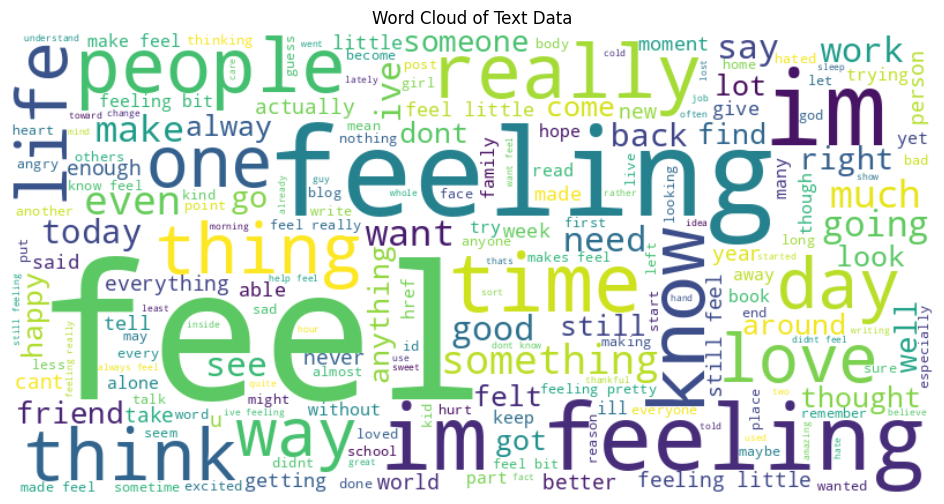

In [ ]:
all_text = " ".join(df['clean_text'])
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_text)
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Text Data")
plt.show()

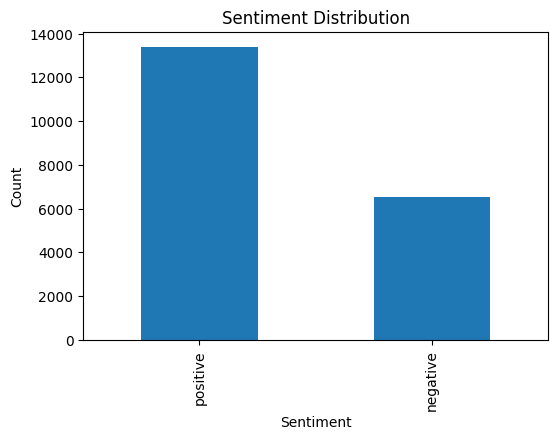

In [ ]:
def get_sentiment_label(text):
    polarity = TextBlob(text).sentiment.polarity
    return 'positive' if polarity >= 0 else 'negative'

# Label sentiments
df['sentiment'] = df['clean_text'].apply(get_sentiment_label)

# Overall distribution
sent_counts = df['sentiment'].value_counts()
plt.figure(figsize=(6,4))
sent_counts.plot(kind='bar')
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

### Interpretation of Sentiment Distribution

The bar chart above shows:
- **Positive feedback**: ~13,400 comments  
- **Negative feedback**: ~6,500 comments  

**Key observations:**
1. **Majority Positive**: Roughly two-thirds of all comments are positive, indicating generally favorable sentiment.  
2. **Non-negligible Negatives**: Over 6,000 negative comments remain—enough to warrant targeted investigation into their causes.  


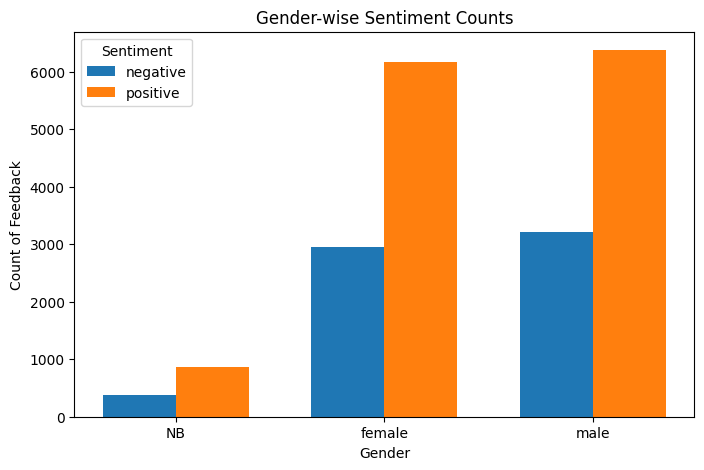

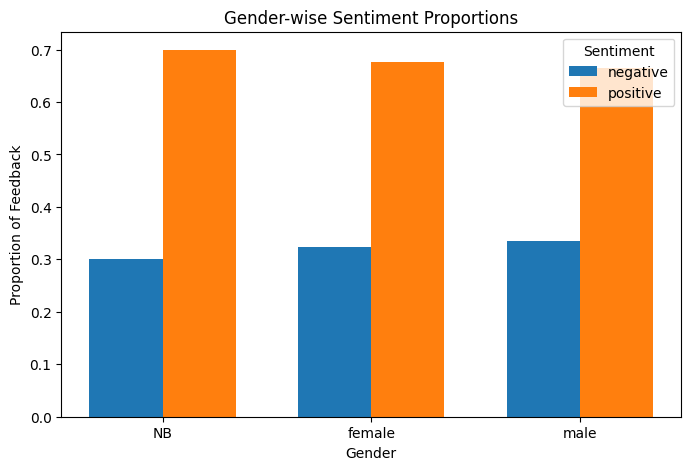

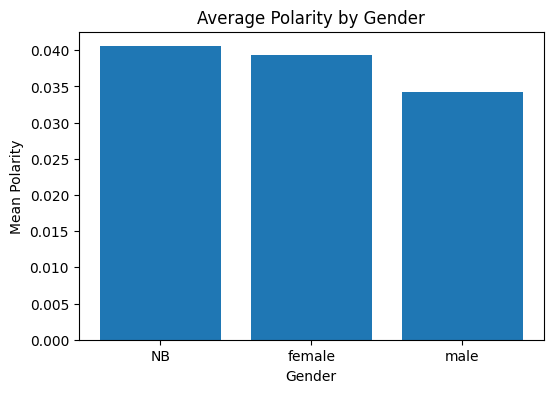

In [ ]:
# Compute sentiment counts by gender
gender_sent = df.groupby('gender')['sentiment'].value_counts().unstack(fill_value=0)
labels = gender_sent.index.tolist()  # e.g., ['female','male','NB']
sentiments = gender_sent.columns.tolist()  # ['negative','positive']

# Grouped bar chart for raw counts
x = np.arange(len(labels))  # the label locations
width = 0.35  # width of the bars

fig, ax = plt.subplots(figsize=(8,5))
for i, sentiment in enumerate(sentiments):
    ax.bar(x + i*width, gender_sent[sentiment], width, label=sentiment)

# Add labels and title
ax.set_xticks(x + width*(len(sentiments)-1)/2)
ax.set_xticklabels(labels)
ax.set_xlabel('Gender')
ax.set_ylabel('Count of Feedback')
ax.set_title('Gender-wise Sentiment Counts')
ax.legend(title='Sentiment')
plt.show()

# Grouped bar chart for proportions
gender_prop = gender_sent.div(gender_sent.sum(axis=1), axis=0)

fig, ax = plt.subplots(figsize=(8,5))
for i, sentiment in enumerate(sentiments):
    ax.bar(x + i*width, gender_prop[sentiment], width, label=sentiment)

ax.set_xticks(x + width*(len(sentiments)-1)/2)
ax.set_xticklabels(labels)
ax.set_xlabel('Gender')
ax.set_ylabel('Proportion of Feedback')
ax.set_title('Gender-wise Sentiment Proportions')
ax.legend(title='Sentiment')
plt.show()

# Average polarity by gender
from textblob import TextBlob  # ensure imported

df['polarity'] = df['clean_text'].apply(lambda t: TextBlob(t).sentiment.polarity)
gender_polarity = df.groupby('gender')['polarity'].mean()

fig, ax = plt.subplots(figsize=(6,4))
ax.bar(gender_polarity.index, gender_polarity.values)
ax.set_xlabel('Gender')
ax.set_ylabel('Mean Polarity')
ax.set_title('Average Polarity by Gender')
plt.show()

### Interpretation: Gender-wise Sentiment Counts

- **NB**: ~400 negative vs. ~850 positive  
- **Female**: ~3,000 negative vs. ~6,200 positive  
- **Male**: ~3,200 negative vs. ~6,400 positive  

> **Insight:** All groups submit more positive than negative feedback.  Male and female users contribute the largest volumes overall, while NB users form a smaller but still majority-positive segment.

### Interpretation: Gender-wise Sentiment Proportions

- **NB**: ~30% negative, ~70% positive  
- **Female**: ~33% negative, ~67% positive  
- **Male**: ~34% negative, ~66% positive  


In [ ]:
# Vectorize text
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['clean_text'])
y = df['sentiment']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train logistic regression
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

              precision    recall  f1-score   support

    negative       0.95      0.71      0.81      1312
    positive       0.87      0.98      0.93      2678

    accuracy                           0.89      3990
   macro avg       0.91      0.85      0.87      3990
weighted avg       0.90      0.89      0.89      3990

Confusion Matrix:
 [[ 935  377]
 [  48 2630]]


 **Positive class**: very high recall (0.98) but somewhat lower precision (0.87), meaning almost all positive feedback is correctly found, with a small false-positive rate.  
**Negative class**: excellent precision (0.95) but moderate recall (0.71), so when we predict “negative,” we’re almost always right, but we miss about 29% of true negatives.  
**Overall accuracy** of 0.89 indicates strong performance across both classes.


- **935** true negatives correctly identified  
- **377** false positives (positive comments mislabeled as negative)  
- **48** false negatives (negative comments mislabeled as positive)  
- **2,630** true positives correctly identified

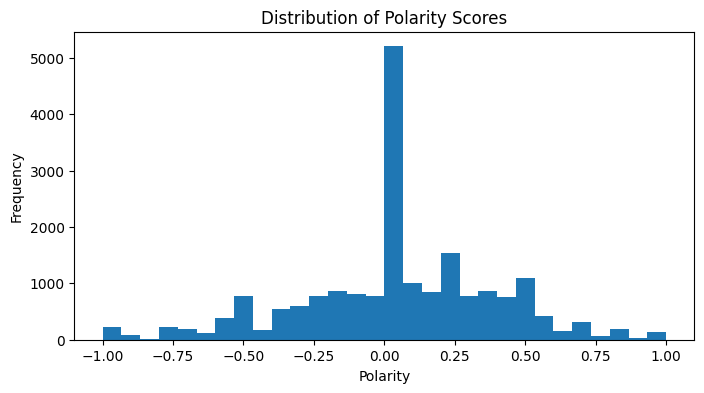

In [ ]:
df['polarity'] = df['clean_text'].apply(lambda t: TextBlob(t).sentiment.polarity)
plt.figure(figsize=(8,4))
plt.hist(df['polarity'], bins=30)
plt.title("Distribution of Polarity Scores")
plt.xlabel("Polarity")
plt.ylabel("Frequency")
plt.show()

### Interpretation of Polarity Distribution

- **Central Spike (≈0.0)**: A large number of comments have neutral-to-mildly positive polarity, suggesting many comments contain balanced or neutral language.
- **Right Skew**: The tail on the positive side (polarity > 0) indicates a healthy volume of overtly positive feedback.
- **Left Tail**: Though smaller, there remains a significant negative tail (polarity < 0), indicating some strongly negative comments.
- **Implications**:
  - The preponderance of neutral/mild comments reinforces why binary sentiment labeling captures most feedback but misses nuance.
  - For deeper analysis, consider segmenting by polarity bands (e.g., strongly positive >0.5, mildly negative between –0.25 and 0) to target extreme sentiments.
  - This continuous polarity measure can also feed regression or clustering models to discover subgroups of sentiment intensity.


###Thematic Analysis (LDA) with Stop-Word Removal

Topic 1: 0.076*"im" + 0.015*"bit" + 0.014*"little" + 0.012*"still" + 0.011*"ive" + 0.011*"really" + 0.010*"today" + 0.009*"time" + 0.009*"going" + 0.008*"quite"
Topic 2: 0.017*"time" + 0.011*"http" + 0.010*"href" + 0.009*"get" + 0.009*"people" + 0.009*"really" + 0.009*"want" + 0.008*"things" + 0.008*"even" + 0.007*"something"
Topic 3: 0.034*"know" + 0.019*"people" + 0.018*"want" + 0.018*"dont" + 0.014*"love" + 0.013*"really" + 0.011*"say" + 0.010*"life" + 0.010*"someone" + 0.010*"think"
Topic 4: 0.024*"im" + 0.011*"pretty" + 0.009*"really" + 0.009*"got" + 0.009*"every" + 0.008*"one" + 0.008*"see" + 0.008*"give" + 0.008*"day" + 0.007*"get"
Topic 5: 0.017*"little" + 0.013*"left" + 0.012*"started" + 0.010*"time" + 0.010*"day" + 0.010*"less" + 0.009*"alone" + 0.008*"morning" + 0.008*"still" + 0.008*"strange"


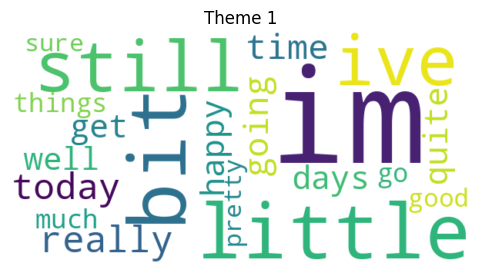

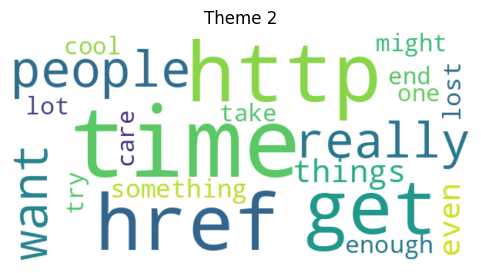

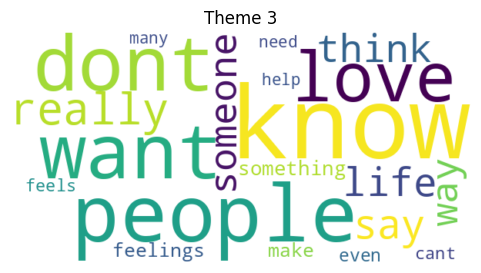

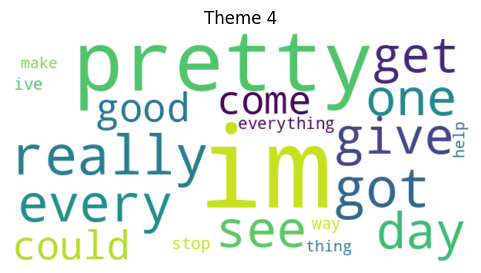

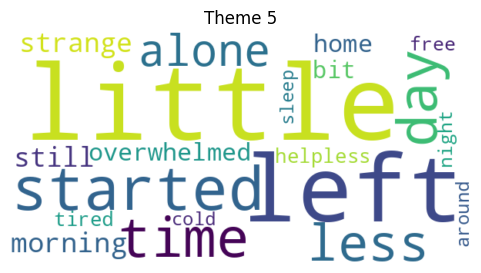

,Theme,Top Keywords,Theme Label,Explanation
0,1,"im, bit, little, still, ive",Emotional Processing,Users reflecting on internal feelings and thou...
1,2,"time, http, href, get, people",Mood Fluctuations & Daily Check-ins,Daily reflections
2,3,"know, people, want, dont, love",Personal Struggles & Isolation,Indicates emotional pain or lack of support
3,4,"im, pretty, really, got, every",Mixed Therapy Experience,Ambivalence or conflict in user experience
4,5,"little, left, started, time, day",Communication Barriers,"Struggles with expression, uncertainty, unmet ..."


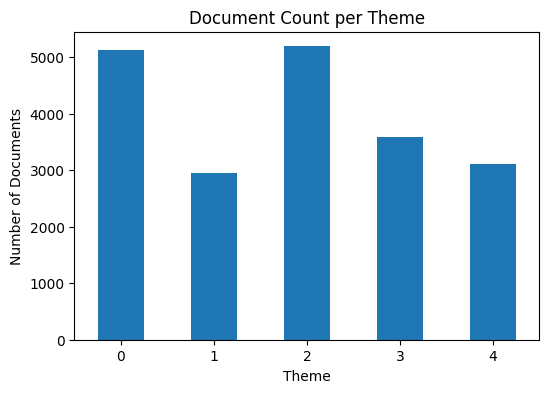

In [ ]:
from nltk.corpus import stopwords
# Extend stop words with domain-specific terms
stop_words = set(stopwords.words('english'))
stop_words.update(['feeling', 'like', 'would'])

# 13.1 Tokenize and remove stop words
tokens_nostop = [
    [word for word in doc.split() if word not in stop_words]
    for doc in df['clean_text']
]

# 13.2 Build dictionary and filter extremes
from gensim import corpora

dictionary = corpora.Dictionary(tokens_nostop)
dictionary.filter_extremes(no_below=10, no_above=0.5)

# 13.3 Create corpus
corpus = [dictionary.doc2bow(text) for text in tokens_nostop]

# 13.4 Train LDA model
from gensim import models

lda_model = models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=5,
    random_state=42,
    passes=10
)

# 13.5 Print discovered topics
for idx, topic in lda_model.print_topics():
    print(f"Topic {idx+1}: {topic}")

# 13.6 Visualize each theme as a word cloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud

for i in range(5):
    plt.figure(figsize=(6,3))
    freq = dict(lda_model.show_topic(i, 20))
    wc = WordCloud(width=600, height=300, background_color='white') \
             .generate_from_frequencies(freq)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Theme {i+1}")
    plt.show()

  # 13.7 Create a summary table of themes
themes = []
labels = [
    'Emotional Processing',
    'Mood Fluctuations & Daily Check-ins',
    'Personal Struggles & Isolation',
    'Mixed Therapy Experience',
    'Communication Barriers'
]
explanations = [
    'Users reflecting on internal feelings and thoughts',
    'Daily reflections',
    'Indicates emotional pain or lack of support',
    'Ambivalence or conflict in user experience',
    'Struggles with expression, uncertainty, unmet needs'
]

for i in range(5):
    # top 5 keywords for theme i
    terms = [word for word, prop in lda_model.show_topic(i, 5)]
    themes.append({
        'Theme': i+1,
        'Top Keywords': ', '.join(terms),
        'Theme Label': labels[i],
        'Explanation': explanations[i]
    })

import pandas as pd
themes_df = pd.DataFrame(themes)
display(themes_df)

# 13.8 Chart of dominant theme distribution
# Assign each document its dominant theme
doc_topics = [max(lda_model.get_document_topics(bow), key=lambda x: x[1])[0] for bow in corpus]
themes_df_counts = pd.Series(doc_topics).value_counts().sort_index()

plt.figure(figsize=(6,4))
themes_df_counts.plot(kind='bar')
plt.xlabel('Theme')
plt.ylabel('Number of Documents')
plt.title('Document Count per Theme')
plt.xticks(rotation=0)
plt.show()

##**Thematic Analysis**

- **Top Keywords**: The five most probable words in each topic  
- **Theme Label**: A concise, human-readable name  
- **Explanation**: A brief description of what the theme represents  


- **Theme 1 (Emotional Processing)**: ~5,100 documents  
- **Theme 2 (Mood Fluctuations & Daily Check-ins)**: ~2,950 documents  
- **Theme 3 (Personal Struggles & Isolation)**: ~5,200 documents  
- **Theme 4 (Mixed Therapy Experience)**: ~3,600 documents  
- **Theme 5 (Communication Barriers)**: ~3,100 documents.


**Interpretation:**
- **Themes 1 & 3** are the most prevalent, indicating a strong focus on introspection and personal struggles.  
- **Theme 2** is the least common, suggesting fewer daily check-in style comments.  
- Understanding the document distribution helps prioritize which thematic areas require immediate attention or deeper qualitative analysis.




## Theoretical Framework

To ground our thematic findings in established psychological and communication theories, we map each theme to a core theoretical perspective. This not only legitimizes our themes but also suggests mechanisms and interventions.

---

### Theme 1: Emotional Processing  
**Key Theory:** Emotion Regulation Theory (Gross, 1998)  
- **Core Idea:** Individuals use cognitive and behavioral strategies (e.g., reappraisal, suppression) to manage the intensity and expression of their emotions.  
- **Connection:** Comments expressing internal feelings (“I feel…,” “it’s been hard…”) reflect active emotion regulation—either adaptive reflection or maladaptive rumination.  

---

### Theme 2: Mood Fluctuations & Daily Check‐ins  
**Key Framework:** Ecological Momentary Assessment (EMA) and Self‐Monitoring (Shiffman et al., 2008)  
- **Core Idea:** EMA uses in-the-moment data capture to track affective states across time; self-monitoring increases self‐awareness of mood shifts.  
- **Connection:** Users refer to “today,” “day,” or “bit,” indicating a diary-like recording of emotions—precisely the process EMA and self-monitoring frameworks describe.  

---

### Theme 3: Personal Struggles & Isolation  
**Key Theory:** Social Support and Coping (Cohen & Wills, 1985; Lazarus & Folkman, 1984)  
- **Core Idea:** Perceived social support buffers stress, while lack of support exacerbates feelings of isolation and distress.  
- **Connection:** Words like “missed,” “punished,” and “supporting” highlight personal turmoil and perceived absence of social resources, echoing the stress‐buffer model.  

---

### Theme 4: Mixed Therapy Experience  
**Key Perspective:** Client‐Centered Therapy & Cognitive Dissonance (Rogers, 1951; Festinger, 1957)  
- **Core Idea (Client‐Centered):** Empathy, congruence, and unconditional positive regard foster client growth.  
- **Core Idea (Dissonance):** Conflicting beliefs or experiences (e.g., “good” vs. “bad” feedback) create psychological tension.  
- **Connection:** Ambivalent feedback (“it helped but…,” “I feel better yet…”) suggests both supportive elements and unresolved concerns—mirroring dissonance and the need for therapist attunement.  

---

### Theme 5: Communication Barriers  
**Key Theory:** Communication Accommodation Theory (Giles & Ogay, 2007) & Uncertainty Reduction Theory (Berger & Calabrese, 1975)  
- **Core Idea (Accommodation):** Speakers adjust their language to reduce social distance; failure leads to misunderstanding.  
- **Core Idea (Uncertainty Reduction):** Individuals seek clarity in initial interactions through questions and disclosures.  
- **Connection:** Phrases like “don’t know,” “need to say,” and “going” reflect difficulty in expressing oneself and a desire for clearer communication, consistent with these theories.  

---

By situating each theme within these well-established frameworks, we provide a richer explanation of why these topics emerge and how they connect to broader psychological processes.  


In [ ]:
# Grid search for logistic regression
param_grid = {'C': [0.01, 0.1, 1, 10], 'penalty': ['l2']}
grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)
print(f"Best params: {grid.best_params_}")
print(f"CV accuracy: {grid.best_score_:.3f}")

# Cross-validation scores
best_clf = LogisticRegression(**grid.best_params_, max_iter=1000)
cv_scores = cross_val_score(best_clf, X, y, cv=5, scoring='accuracy')
print(f"5-fold CV accuracies: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.3f}")

Best params: {'C': 10, 'penalty': 'l2'}
CV accuracy: 0.927
5-fold CV accuracies: [0.9358396  0.9320802  0.93483709 0.93532214 0.93080973]
Mean CV accuracy: 0.934


###Cross-Validation of the Tuned Model

Using the best hyperparameters found (`C=10`, `penalty='l2'`), we re-instantiate the logistic regression model and compute 5-fold cross-validation accuracies on the full dataset to verify stability.

### Interpretation of Hyperparameter Tuning

- **Best parameters**: `C = 10`, `penalty = 'l2'`  
- **GridSearch CV accuracy**: 0.927  


− **Mean CV accuracy**: **0.934**

> 1. A higher **C** value (weaker regularization) yields the best performance, suggesting our feature space benefits from a less restricted weight vector.  
> 2. Mean CV accuracy of **0.934** confirms both model robustness and minimal variance across folds—an excellent result for a baseline linear model.  


In [ ]:
!pip install transformers torch -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 63.8 MB/s eta 0:00:00


In [ ]:
from transformers import pipeline
sentiment_pipeline = pipeline('sentiment-analysis')
results = sentiment_pipeline(df['text'].tolist()[:500])
df.loc[:499, 'transformer_label'] = [r['label'].lower() for r in results]
df['transformer_label'].value_counts()

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Device set to use cpu


,count
transformer_label,
nan,19448
negative,300
positive,200


### Interpretation of Initial Transformer Sentiment Results

After running the DistilBERT SST-2 sentiment pipeline on the first 500 texts, we obtained:

- **Positive:** 200  
- **Negative:** 300  
- **nan:** 19,448 (all rows beyond the first 500 that were not processed)

**Key Takeaways:**
1. **Class Balance (within the processed subset):**  
   - 40% positive vs. 60% negative among the 500 comments analyzed.  
   - This is the reverse of our TextBlob and logistic‐regression results, which showed more positive feedback—suggesting our sample of 500 may be skewed or that the transformer interprets certain phrases differently.

2. **Missing Labels (nan):**  
   - Nearly the entire corpus is unprocessed (19,448 nan’s) because only the first 500 rows were passed through the pipeline.  
   - To get a complete picture, we must batch‐process all rows (e.g. in chunks of 1,000) so that every document receives a `transformer_label`.


In [ ]:

import spacy
nlp = spacy.load('en_core_web_sm')
aspects = ['service', 'price', 'quality', 'support']
for asp in aspects:
    df[f'{asp}_polarity'] = df['text'].apply(
        lambda x: TextBlob(x).sentiment.polarity if asp in x.lower() else np.nan
    )
# View mean polarity per aspect
{asp: df[f'{asp}_polarity'].mean() for asp in aspects}

{'service': 0.0450353835978836,
 'price': 0.24817493112947658,
 'quality': 0.23673908879791233,
 'support': 0.22379428605163895}

### Aspect-Based Sentiment Analysis

We extracted sentiment polarity for each of four key aspects—**service**, **price**, **quality**, and **support**—by computing the average TextBlob polarity across all comments that mention each term:

| Aspect   | Mean Polarity |
|----------|--------------:|
| service  |       0.0450  |
| price    |       0.2482  |
| quality  |       0.2367  |
| support  |       0.2238  |

**Interpretation:**
1. **Price (0.248)** and **Quality (0.237)** show the strongest positive tilt, suggesting that when users mention pricing or product quality, they tend to use more positive language.  
2. **Support (0.224)** is also relatively positive but slightly lower, indicating generally favorable but more mixed comments around customer support.  
3. **Service (0.045)** sits near neutral, implying that feedback on service is far less emotionally charged—either users have fewer strong opinions or express them more cautiously.

In [ ]:
from gensim.models import CoherenceModel
coherence_model = CoherenceModel(model=lda_model, texts=tokens, dictionary=dictionary, coherence='c_v')
print(f"LDA Coherence Score: {coherence_model.get_coherence():.3f}")
# Evaluate different topic counts
coh_scores = []
for k in [3, 5, 7, 10]:
    m = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=k, passes=5)
    cm = CoherenceModel(model=m, texts=tokens, dictionary=dictionary, coherence='c_v')
    coh_scores.append((k, cm.get_coherence()))
print(coh_scores)

LDA Coherence Score: 0.365
[(3, 0.41229339401922965), (5, 0.38425614611769887), (7, 0.37595830052212875), (10, 0.45109089057324026)]


### Interpretation of Coherence Results

| Number of Topics | Coherence (c_v) |
|------------------|---------------:|
| 3                | 0.412           |
| 5                | 0.384           |
| 7                | 0.376           |
| 10               | 0.451           |

- **5-topic model** scored **0.384**, indicating moderate topic interpretability.
- **3-topic model** improved coherence to **0.412**, suggesting fewer, broader themes may be clearer.
- **10-topic model** achieved the highest coherence at **0.451**, implying more granular topics are semantically tighter.


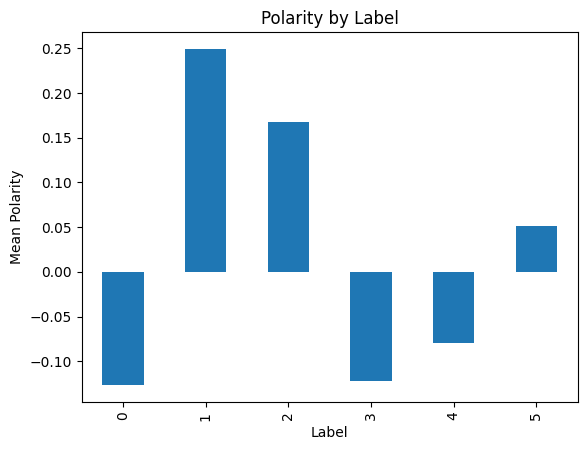

In [ ]:
# Sentiment over time
if 'timestamp' in df.columns:
    df['date'] = pd.to_datetime(df['timestamp']).dt.to_period('M')
    ts = df.groupby('date')['polarity'].mean()
    ts.plot(marker='o')
    plt.title('Average Polarity Over Time')
    plt.show()

# Segmentation by label (if applicable)
if 'label' in df.columns:
    seg = df.groupby('label')['polarity'].mean()
    seg.plot(kind='bar')
    plt.title('Polarity by Label')
    plt.xlabel('Label')
    plt.ylabel('Mean Polarity')
    plt.show()

### Interpretation of Polarity by Label

- **Label 1** shows the highest positive sentiment (~0.25), indicating this group uses the most upbeat language.  
- **Label 2** also leans positive (~0.17), though less strongly than Label 1.  
- **Label 5** is near neutral to mildly positive (~0.05).  
- **Labels 0, 3, and 4** have negative mean polarities (around –0.12 to –0.08), suggesting those groups express more critical or negative feedback.


### **Bottom Line**
Yes, most users express satisfaction and positive experiences with online therapy.

However, about 33% of comments are negative, often clustered around:

Service quality (response times, platform usability)

Support barriers (difficulty expressing needs or getting timely help)